In [57]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [59]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [60]:
train_data = datasets.CIFAR10("dataset", train=True, download=True, transform=train_transforms)
print(len(train_data))

test_data = datasets.CIFAR10("dataset", train=False, transform=test_transforms)
print(len(test_data))

Files already downloaded and verified
50000
10000


In [61]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [62]:
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()

        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fully_connected_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layer(x)

        return x

In [63]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()

        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.02, inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fully_connected_layer = nn.Sequential(
            nn.Linear(2048, 10),
        )

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layer(x)

        return x

In [64]:
initial_student_model = StudentModel()
distilled_student_model = StudentModel()
teacher_model = TeacherModel()

In [65]:
temperature = 20.0
distillation_weight = 0.5

optimizer_teacher = optim.SGD(teacher_model.parameters(), 0.01)
optimizer_student = optim.SGD(initial_student_model.parameters(), 0.01)
optimizer_distilled_student = optim.SGD(distilled_student_model.parameters(), 0.05)

loss_func = nn.KLDivLoss(reduction='batchmean').to(device)
cross_entropy_loss = nn.CrossEntropyLoss(reduction='mean').to(device)

In [66]:
def train_teacher(epochs, teacher_model):
    teacher_model = teacher_model.to(device)
    teacher_model.train()

    train_loss_list = []
    val_loss_list = []
    best_val_acc = 0.0
    best_teacher_model_weights = deepcopy(teacher_model.state_dict())

    for epoch in range(epochs):
        train_epoch_loss = 0.0
        val_epoch_loss = 0.0
        train_correct = 0.0
        val_correct = 0.0

        teacher_model.train()

        i = 0

        for (data, label) in train_loader:
            if i % 200 == 0:
                print(f'epoch {epoch}/{epochs} batch {i}/{len(train_loader)}')

            i += 1

            data = data.to(device)
            label = label.to(device)
            out = teacher_model(data)
            predicted = out.argmax(dim=1, keepdim=True)

            train_correct += predicted.eq(label.view_as(predicted)).sum().item()
            loss = cross_entropy_loss(out, label)

            optimizer_teacher.zero_grad()
            loss.backward()
            optimizer_teacher.step()

            train_epoch_loss += loss.item()

        train_epoch_loss /= len(train_loader.dataset)
        train_epoch_acc = train_correct / len(train_loader.dataset)

        with torch.no_grad():
            teacher_model.eval()

            for (data, label) in test_loader:
                data = data.to(device)
                label = label.to(device)
                out = teacher_model(data)
                predicted = out.argmax(dim=1, keepdim=True)
                val_correct += predicted.eq(label.view_as(predicted)).sum().item()
                loss = cross_entropy_loss(out, label)
                val_epoch_loss += loss.item()

        val_epoch_acc = val_correct / len(test_loader.dataset)
        val_epoch_loss /= len(test_loader.dataset)

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_teacher_model_weights = deepcopy(teacher_model.state_dict())

        train_loss_list.append(train_epoch_loss)
        val_loss_list.append(val_epoch_loss)

        print(
            f"epoch: {epoch + 1} \n train loss: {train_epoch_loss:4.4f}, train accuracy: {train_epoch_acc} \n val loss: {val_epoch_loss} val accuracy: {val_epoch_acc}\n\n")

    teacher_model.load_state_dict(best_teacher_model_weights)

    plt.plot(train_loss_list)
    plt.plot(val_loss_list)

In [67]:
def train_student(epochs, initial_student_model):
    initial_student_model = initial_student_model.to(device)
    initial_student_model.train()

    train_loss_list = []
    val_loss_list = []
    best_val_acc = 0.0
    best_student_model_weights = deepcopy(initial_student_model.state_dict())

    for epoch in range(epochs):
        train_epoch_loss = 0.0
        val_epoch_loss = 0.0
        train_correct = 0.0
        val_correct = 0.0

        i = 0

        initial_student_model.train()

        for (data, label) in train_loader:
            if i % 200 == 0:
                print(f'epoch {epoch}/{epochs} batch {i}/{len(train_loader)}')

            i += 1

            data = data.to(device)
            label = label.to(device)
            out = initial_student_model(data)
            pred = out.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(label.view_as(pred)).sum().item()
            loss = cross_entropy_loss(out, label)

            optimizer_student.zero_grad()
            loss.backward()
            optimizer_student.step()

            train_epoch_loss += loss

        train_epoch_loss /= len(train_loader.dataset)
        train_epoch_acc = train_correct / len(train_loader.dataset)

        with torch.no_grad():
            initial_student_model.eval()

            for (data, label) in test_loader:
                data = data.to(device)
                label = label.to(device)
                out = initial_student_model(data)
                pred = out.argmax(dim=1, keepdim=True)

                val_correct += pred.eq(label.view_as(pred)).sum().item()
                loss = cross_entropy_loss(out, label)

                val_epoch_loss += loss

        val_epoch_acc = val_correct / len(test_loader.dataset)
        val_epoch_loss /= len(test_loader.dataset)

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_student_model_weights = deepcopy(initial_student_model.state_dict())

        train_loss_list.append(train_epoch_loss.item())
        val_loss_list.append(val_epoch_loss.item())

        print(
            f"epoch: {epoch + 1} \n train loss: {train_epoch_loss}, train accuracy: {train_epoch_acc} \n val loss: {val_epoch_loss} val accuracy: {val_epoch_acc}\n\n")

    initial_student_model.load_state_dict(best_student_model_weights)
    
    plt.plot(train_loss_list)
    plt.plot(val_loss_list)

In [68]:
def get_knowledge_distillation_loss(student_predicted, teacher_predicted, expected):
    soft_teacher_out = F.softmax(teacher_predicted / temperature, dim=1)
    soft_student_out = F.softmax(student_predicted / temperature, dim=1)

    loss = (1 - distillation_weight) * F.cross_entropy(student_predicted, expected)
    loss += (distillation_weight * temperature * temperature) * loss_func(soft_teacher_out, soft_student_out)

    return loss

In [69]:
def knowledge_distillation(epochs, distilled_student_model, teacher_model):
    distilled_student_model = distilled_student_model.to(device)
    teacher_model = teacher_model.to(device).eval()

    train_loss_list = []
    val_loss_list = []
    best_val_acc = 0.0
    best_distilled_student_model_weights = deepcopy(distilled_student_model.state_dict())

    for epoch in range(epochs):
        train_epoch_loss = 0.0
        val_epoch_loss = 0.0
        train_correct = 0.0
        val_correct = 0.0

        distilled_student_model.train()

        i = 0

        for (data, label) in train_loader:
            if i % 200 == 0:
                print(f'epoch {epoch}/{epochs} batch {i}/{len(train_loader)}')

            i += 1

            data = data.to(device)
            label = label.to(device)
            student_out = distilled_student_model(data)
            teacher_out = teacher_model(data)
            pred = student_out.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(label.view_as(pred)).sum().item()
            loss = get_knowledge_distillation_loss(student_out, teacher_out, label)

            optimizer_distilled_student.zero_grad()
            loss.backward()
            optimizer_distilled_student.step()

            train_epoch_loss += loss

        train_epoch_loss /= len(train_loader.dataset)
        train_epoch_acc = train_correct / len(train_loader.dataset)

        with torch.no_grad():
            distilled_student_model.eval()

            for (data, label) in test_loader:
                data = data.to(device)
                label = label.to(device)
                student_out = distilled_student_model(data)
                teacher_out = teacher_model(data)
                pred = student_out.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(label.view_as(pred)).sum().item()
                loss = get_knowledge_distillation_loss(student_out, teacher_out, label)
                val_epoch_loss += loss

        val_epoch_acc = val_correct / len(test_loader.dataset)
        val_epoch_loss /= len(test_loader.dataset)

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_distilled_student_model_weights = deepcopy(distilled_student_model.state_dict())

        train_loss_list.append(train_epoch_loss.item())
        val_loss_list.append(val_epoch_loss.item())

        print(
            f"epoch: {epoch + 1} \n train loss: {train_epoch_loss}, train accuracy: {train_epoch_acc} \n val loss: {val_epoch_loss} val accuracy: {val_epoch_acc}\n\n")

    distilled_student_model.load_state_dict(best_distilled_student_model_weights)

    plt.plot(train_loss_list)
    plt.plot(val_loss_list)

In [70]:
def get_model_accuracy(model):
    model.eval()
    model.to(device)

    correct = 0
    outputs = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)

            outputs.append(output)

            predicted = output.argmax(dim=1, keepdim=True)

            correct += predicted.eq(target.view_as(predicted)).sum().item()

    return correct / len(test_loader.dataset)

In [71]:
def print_models_evaluation_accuracy(initial_student_model, teacher_model, distilled_student_model):
    initial_student_model_copied = deepcopy(initial_student_model).to(device)
    teacher_model_copied = deepcopy(teacher_model).to(device)
    distilled_student_model_copied = deepcopy(distilled_student_model).to(device)

    teacher_acc = get_model_accuracy(teacher_model_copied)
    initial_student_acc = get_model_accuracy(initial_student_model_copied)
    distilled_student_acc = get_model_accuracy(distilled_student_model_copied)

    print(
        f" teacher accuracy: {teacher_acc:0.4} \n student accuracy: {initial_student_acc:0.4} \n distilled student accuracy: {distilled_student_acc:0.4}")

epoch 0/25 batch 0/1563
epoch 0/25 batch 200/1563
epoch 0/25 batch 400/1563
epoch 0/25 batch 600/1563
epoch 0/25 batch 800/1563
epoch 0/25 batch 1000/1563
epoch 0/25 batch 1200/1563
epoch 0/25 batch 1400/1563
epoch: 1 
 train loss: 0.0471, train accuracy: 0.44478 
 val loss: 0.036151153814792635 val accuracy: 0.5752


epoch 1/25 batch 0/1563
epoch 1/25 batch 200/1563
epoch 1/25 batch 400/1563
epoch 1/25 batch 600/1563
epoch 1/25 batch 800/1563
epoch 1/25 batch 1000/1563
epoch 1/25 batch 1200/1563
epoch 1/25 batch 1400/1563
epoch: 2 
 train loss: 0.0314, train accuracy: 0.63806 
 val loss: 0.02786839281618595 val accuracy: 0.6838


epoch 2/25 batch 0/1563
epoch 2/25 batch 200/1563
epoch 2/25 batch 400/1563
epoch 2/25 batch 600/1563
epoch 2/25 batch 800/1563
epoch 2/25 batch 1000/1563
epoch 2/25 batch 1200/1563
epoch 2/25 batch 1400/1563
epoch: 3 
 train loss: 0.0248, train accuracy: 0.7191 
 val loss: 0.02247040946483612 val accuracy: 0.7539


epoch 3/25 batch 0/1563
epoch 3/25 batch 20

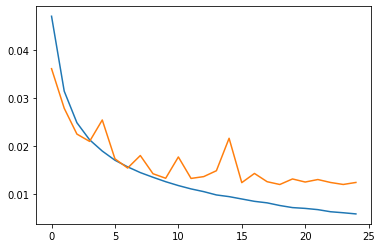

In [72]:
train_teacher(25, teacher_model)

epoch 0/25 batch 0/1563
epoch 0/25 batch 200/1563
epoch 0/25 batch 400/1563
epoch 0/25 batch 600/1563
epoch 0/25 batch 800/1563
epoch 0/25 batch 1000/1563
epoch 0/25 batch 1200/1563
epoch 0/25 batch 1400/1563
epoch: 1 
 train loss: 0.04463708773255348, train accuracy: 0.47682 
 val loss: 0.03884551301598549 val accuracy: 0.5555


epoch 1/25 batch 0/1563
epoch 1/25 batch 200/1563
epoch 1/25 batch 400/1563
epoch 1/25 batch 600/1563
epoch 1/25 batch 800/1563
epoch 1/25 batch 1000/1563
epoch 1/25 batch 1200/1563
epoch 1/25 batch 1400/1563
epoch: 2 
 train loss: 0.03130469098687172, train accuracy: 0.64506 
 val loss: 0.027802370488643646 val accuracy: 0.6841


epoch 2/25 batch 0/1563
epoch 2/25 batch 200/1563
epoch 2/25 batch 400/1563
epoch 2/25 batch 600/1563
epoch 2/25 batch 800/1563
epoch 2/25 batch 1000/1563
epoch 2/25 batch 1200/1563
epoch 2/25 batch 1400/1563
epoch: 3 
 train loss: 0.02598254755139351, train accuracy: 0.70854 
 val loss: 0.027887172996997833 val accuracy: 0.6851


ep

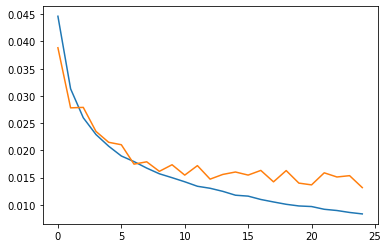

In [73]:
train_student(25, initial_student_model)

epoch 0/25 batch 0/1563
epoch 0/25 batch 200/1563
epoch 0/25 batch 400/1563
epoch 0/25 batch 600/1563
epoch 0/25 batch 800/1563
epoch 0/25 batch 1000/1563
epoch 0/25 batch 1200/1563
epoch 0/25 batch 1400/1563
epoch: 1 
 train loss: -14.998409271240234, train accuracy: 0.52716 
 val loss: -15.020909309387207 val accuracy: 0.6127


epoch 1/25 batch 0/1563
epoch 1/25 batch 200/1563
epoch 1/25 batch 400/1563
epoch 1/25 batch 600/1563
epoch 1/25 batch 800/1563
epoch 1/25 batch 1000/1563
epoch 1/25 batch 1200/1563
epoch 1/25 batch 1400/1563
epoch: 2 
 train loss: -15.00456428527832, train accuracy: 0.69394 
 val loss: -15.025636672973633 val accuracy: 0.7285


epoch 2/25 batch 0/1563
epoch 2/25 batch 200/1563
epoch 2/25 batch 400/1563
epoch 2/25 batch 600/1563
epoch 2/25 batch 800/1563
epoch 2/25 batch 1000/1563
epoch 2/25 batch 1200/1563
epoch 2/25 batch 1400/1563
epoch: 3 
 train loss: -15.006563186645508, train accuracy: 0.74438 
 val loss: -15.025818824768066 val accuracy: 0.7383


epoch

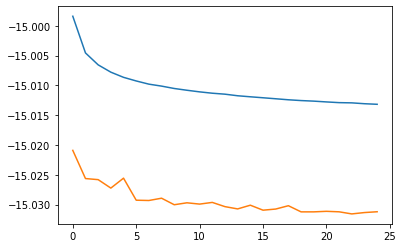

In [74]:
knowledge_distillation(25, distilled_student_model, teacher_model)

In [75]:
print(f"teacher parameters amount: {sum(p.numel() for p in teacher_model.parameters())}")
print(f"student parameters amount: {sum(p.numel() for p in initial_student_model.parameters())}")

teacher parameters amount: 19357706
student parameters amount: 1771786


In [76]:
print_models_evaluation_accuracy(initial_student_model, teacher_model, distilled_student_model)

 teacher accuracy: 0.8856 
 student accuracy: 0.8624 
 distilled student accuracy: 0.8766
